# Apply corrections to pmaps
### JAH 17/10/18

<i>
This notebook applies corrections to h-dsts to produce an energy spectrum

</i>

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Fri Oct 19 19:15:38 2018


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Notebook configuration

In [3]:
run_number             = 6348
tag                    = "trigger2_v0.9.9_20180921_krbg1300" 
input_hdst_filenames   = [f"$IC_DATA/{run_number}/pmaps/pmaps_0000_{run_number}_{tag}.h5"]
# bootstrap correction
run_number_correction  = run_number
correction_filename    = f"$IC_DATA/maps/kr_corrections_run{run_number_correction}.h5"
output_filename        = f"corhits_{run_number}.h5"

### Imports

In [4]:
import os
import time
import datetime

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
import collections       as collections
import pandas            as pd

from   invisible_cities.io.hits_io         import load_hits
from   invisible_cities.io.dst_io          import load_dst
import invisible_cities.io.pmaps_io        as pmio

import invisible_cities.database.load_db           as db

from invisible_cities.core .core_functions import in_range

import krcal.utils.hst_extend_functions   as hst
import krcal.dev.corrections              as corrections

import csth.utils.pmaps_functions            as pmapsf
import csth.utils.hpeak_tables               as hptab
import csth.utils.hpeak_pmaps_functions      as hppmap
import csth.utils.hpeak_plot_functions       as hpplot


In [5]:
# Plotting style
default_cmap = "jet"
figure_size  = 10, 8
font_size    = 14

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size

### Initialization

In [6]:
correction_filename = os.path.expandvars(correction_filename)
calibrate = corrections.Calibration(correction_filename, 'scale')

datasipm = db.DataSiPM(run_number)
sipms_xs, sipms_ys = datasipm.X.values, datasipm.Y.values

calibration file : /Users/hernando/investigacion/NEXT/data/runIV//maps/kr_corrections_run6348.h5
node             : scale
Energy   scale : 10194.4 (pes)
Lifetime scale : 4751.3 (us) 
Charge   scale : 603.6 (pes)


### read pmaps

In [7]:
input_hst_filenames = [os.path.expandvars(fi) for fi in input_hdst_filenames]

In [8]:
print(input_hst_filenames)

['/Users/hernando/investigacion/NEXT/data/runIV//6348/pmaps/pmaps_0000_6348_trigger2_v0.9.9_20180921_krbg1300.h5']


In [9]:
pmaps = pmapsf.get_pmaps(input_hst_filenames[0])

### correctios of hits step by step

In [10]:
evtlist = hppmap.event_list(pmaps)
evtlist

EventList(event=[5, 9, 47, 160, 178, 188, 192, 213, 217, 220, 261, 271, 273, 274, 275, 305, 363, 366], peak=[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1])

In [11]:
etab = hppmap.event_table(evtlist, pmaps, 10)
edf  = hptab .df_from_etable(etab)
edf.head()

,event,peak,nslices,nhits,noqhits,time,s1e,t0,rmax,x0,y0,z0,q0,e0,x,y,z,q,e
0,5,0,36,240,13764,0.0,172.335297,378.170655,0.0,0.0,0.0,0.0,6678.405273,159915.234375,0.0,0.0,0.0,0.0,0.0
1,9,0,39,256,12458,0.0,171.858398,473.307052,0.0,0.0,0.0,0.0,7625.978516,153441.796875,0.0,0.0,0.0,0.0,0.0
2,47,0,25,251,8524,0.0,173.360474,531.961168,0.0,0.0,0.0,0.0,9084.175781,157533.890625,0.0,0.0,0.0,0.0,0.0
3,160,0,14,108,3616,0.0,92.094521,523.466149,0.0,0.0,0.0,0.0,4898.324219,108656.960938,0.0,0.0,0.0,0.0,0.0
4,178,0,22,208,5490,0.0,188.094254,346.333260,0.0,0.0,0.0,0.0,6761.871582,115633.554688,0.0,0.0,0.0,0.0,0.0


In [12]:
etab = hppmap.event_table(evtlist, pmaps)
edf  = hptab .df_from_etable(etab)
edf.head()

,event,peak,nslices,nhits,noqhits,time,s1e,t0,rmax,x0,y0,z0,q0,e0,x,y,z,q,e
0,5,0,36,372,13632,0.0,172.335297,378.170655,0.0,0.0,0.0,0.0,7713.145020,159915.234375,0.0,0.0,0.0,0.0,0.0
1,9,0,39,386,12328,0.0,171.858398,473.307052,0.0,0.0,0.0,0.0,8620.006836,153441.796875,0.0,0.0,0.0,0.0,0.0
2,47,0,25,370,8405,0.0,173.360474,531.961168,0.0,0.0,0.0,0.0,9986.626953,157533.890625,0.0,0.0,0.0,0.0,0.0
3,160,0,14,165,3559,0.0,92.094521,523.466149,0.0,0.0,0.0,0.0,5328.606445,108656.960938,0.0,0.0,0.0,0.0,0.0
4,178,0,22,317,5381,0.0,188.094254,346.333260,0.0,0.0,0.0,0.0,7616.803711,115633.554688,0.0,0.0,0.0,0.0,0.0


In [13]:
stab = hppmap.slice_table(etab, pmaps)
sdf  = hptab .df_from_stable(stab)
sdf.head()

,event,peak,slice,nhits,rmax,x0,y0,z0,q0,e0,x,y,q,e
0,5,0,0,0,0.0,0.0,0.0,269.804382,0.0,2.777531,0.0,0.0,0.0,0.0
1,5,0,1,0,0.0,0.0,0.0,270.369568,0.0,97.357391,0.0,0.0,0.0,0.0
2,5,0,2,0,0.0,0.0,0.0,271.397034,0.0,363.558990,0.0,0.0,0.0,0.0
3,5,0,3,0,0.0,0.0,0.0,272.414185,0.0,1161.955200,0.0,0.0,0.0,0.0
4,5,0,4,0,0.0,0.0,0.0,273.387024,0.0,2833.937988,0.0,0.0,0.0,0.0


In [14]:
htab = hppmap.hit_table(etab, stab, pmaps, sipms_xs, sipms_ys)
hdf  = hptab .df_from_htable(htab)
hdf.head()

,event,peak,slice,nsipm,x0,y0,z0,q0,e0,q,e
0,5,0,15,733,-45.0,-25.0,284.289673,8.278044,1.0,0.0,0.0
1,5,0,14,734,-45.0,-15.0,283.315369,6.135781,1.0,0.0,0.0
2,5,0,12,741,-35.0,-25.0,281.354492,13.492823,1.0,0.0,0.0
3,5,0,13,741,-35.0,-25.0,282.330627,13.844810,1.0,0.0,0.0
4,5,0,14,741,-35.0,-25.0,283.315369,8.447680,1.0,0.0,0.0


In [15]:
htab = hppmap.calibrate_hits(htab, calibrate)
hdf  = hptab .df_from_htable(htab)
hdf.head()   

,event,peak,slice,nsipm,x0,y0,z0,q0,e0,q,e
0,5,0,15,733,-45.0,-25.0,284.289673,8.278044,1.0,8.489592,0.884069
1,5,0,14,734,-45.0,-15.0,283.315369,6.135781,1.0,6.497313,0.895657
2,5,0,12,741,-35.0,-25.0,281.354492,13.492823,1.0,14.144012,0.890896
3,5,0,13,741,-35.0,-25.0,282.330627,13.844810,1.0,14.517434,0.891067
4,5,0,14,741,-35.0,-25.0,283.315369,8.447680,1.0,8.860833,0.891241


In [16]:
etab, stab, htab = hppmap.update_tables(etab, stab, htab)

In [17]:
edf = hptab.df_from_etable(etab)
sdf = hptab.df_from_stable(stab)
hdf = hptab.df_from_htable(htab)

In [18]:
edf.head()

,event,peak,nslices,nhits,noqhits,time,s1e,t0,rmax,x0,y0,z0,q0,e0,x,y,z,q,e
0,5,0,36,372,13632,0.0,172.335297,378.170655,0.0,130.677970,-19.122095,283.386290,7713.144427,159915.234375,130.692895,-19.220084,283.337389,8748.018755,167498.445005
1,9,0,39,386,12328,0.0,171.858398,473.307052,0.0,133.647856,-103.562490,189.380166,8620.006702,153441.796875,133.700563,-103.762350,189.165336,9787.571454,176833.859432
2,47,0,25,370,8405,0.0,173.360474,531.961168,0.0,-86.020170,-153.229908,129.393429,9986.627108,157533.890625,-85.774842,-153.568398,129.243159,9142.083401,167832.318570
3,160,0,14,165,3559,0.0,92.094521,523.466149,0.0,-33.669768,66.423267,131.148393,5328.606665,108656.960938,-33.708639,66.484804,131.162039,5495.622372,99119.286447
4,178,0,22,317,5381,0.0,188.094254,346.333260,0.0,181.698569,-43.303028,312.466297,7616.803883,115633.554688,181.698405,-43.314122,312.467033,8383.785567,154118.578571


In [19]:
sdf.head()

,event,peak,slice,nhits,rmax,x0,y0,z0,q0,e0,x,y,q,e
0,5,0,0,0,0.0,0.000000,0.000000,269.804382,0.000000,2.777531,0.000000,0.000000,0.000000,2.919211
1,5,0,1,0,0.0,0.000000,0.000000,270.369568,0.000000,97.357391,0.000000,0.000000,0.000000,102.323519
2,5,0,2,0,0.0,0.000000,0.000000,271.397034,0.000000,363.558990,0.000000,0.000000,0.000000,382.103861
3,5,0,3,4,0.0,130.573632,0.208429,272.414185,46.603849,1161.955200,130.573632,0.208429,52.473342,1202.226491
4,5,0,4,8,0.0,130.222911,2.092996,273.387024,120.354049,2833.937988,130.222911,2.092996,136.017804,2934.196561


In [20]:
hdf.head()

,event,peak,slice,nsipm,x0,y0,z0,q0,e0,q,e
0,5,0,15,733,-45.0,-25.0,284.289673,8.278044,159.131535,8.489592,127.385719
1,5,0,14,734,-45.0,-15.0,283.315369,6.135781,115.220188,6.497313,96.457498
2,5,0,12,741,-35.0,-25.0,281.354492,13.492823,292.732853,14.144012,241.542415
3,5,0,13,741,-35.0,-25.0,282.330627,13.844810,262.665293,14.517434,216.467697
4,5,0,14,741,-35.0,-25.0,283.315369,8.447680,158.633968,8.860833,130.897093


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


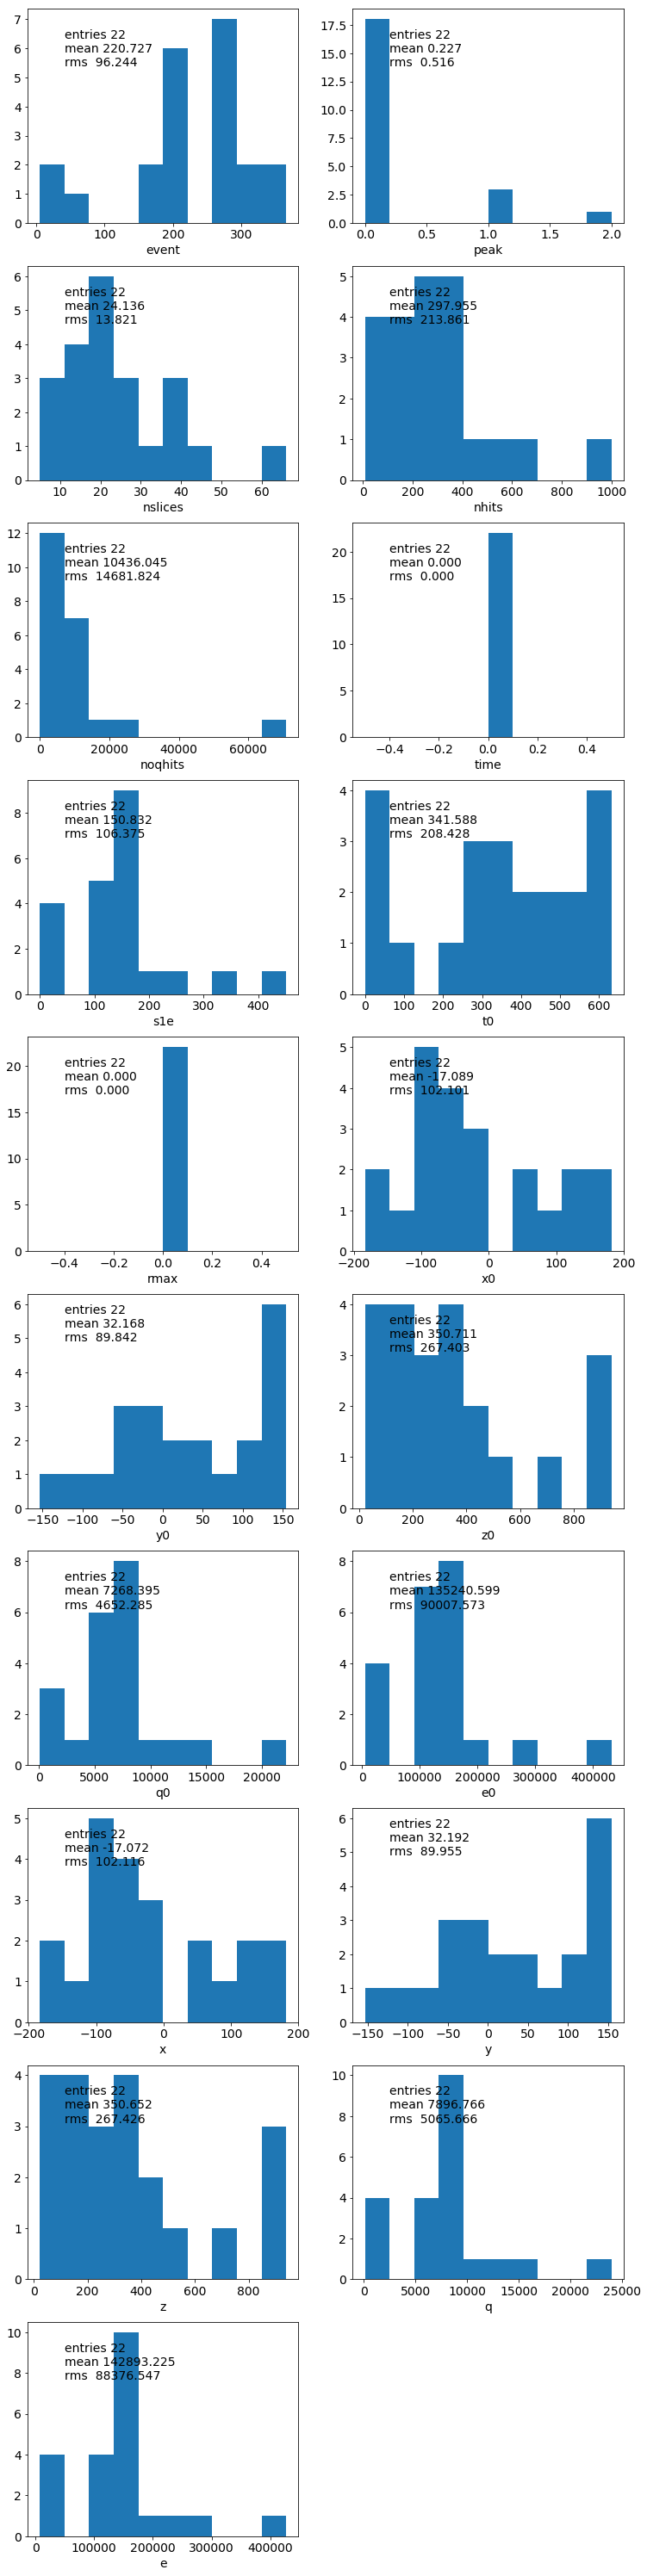

In [21]:
hpplot.plot_var(edf, hptab.edf_names, 10)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


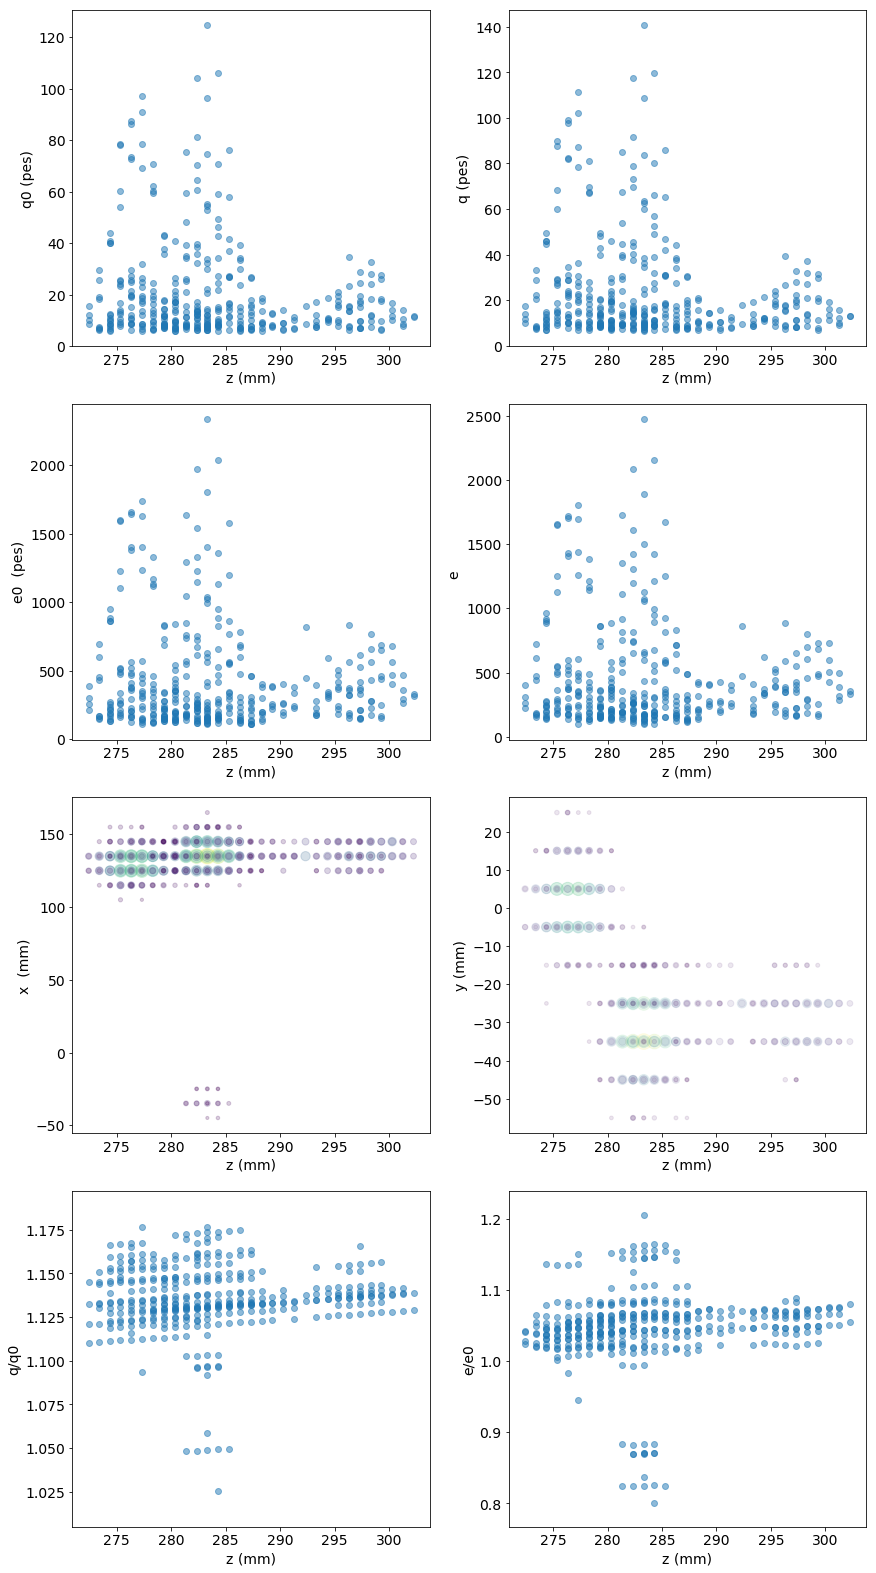

In [22]:
hpplot.plot_vs_z(hdf[hdf.event == 5])

### One go

In [23]:
edf, sdf, hdf = hppmap.hpeaks_dfs(pmaps, sipms_xs, sipms_ys, calibrate, q0min = 3)

In [24]:
edf.head()

,event,peak,nslices,nhits,noqhits,time,s1e,t0,rmax,x0,y0,z0,q0,e0,x,y,z,q,e
0,5,0,36,691,13313,0.0,172.335297,378.170655,0.0,128.906195,-18.466182,283.379153,9029.970556,159915.234375,128.919114,-18.543198,283.337389,10239.456096,167835.651961
1,9,0,39,707,12007,0.0,171.858398,473.307052,0.0,133.909893,-102.559218,189.374181,9955.916378,153441.796875,133.977017,-102.785764,189.165336,11294.437708,178097.394475
2,47,0,25,705,8070,0.0,173.360474,531.961168,0.0,-85.991219,-151.629050,129.383458,11373.607749,157533.890625,-85.765134,-151.944413,129.243159,10236.141212,167758.259951
3,160,0,14,360,3364,0.0,92.094521,523.466149,0.0,-33.123035,66.356868,131.145266,6109.819601,108656.960938,-33.165497,66.426318,131.162039,6279.168163,99774.215533
4,178,0,22,576,5122,0.0,188.094254,346.333260,0.0,180.547191,-42.492219,312.465131,8696.766546,115633.554688,180.547516,-42.505072,312.467033,9419.002495,153493.303201


/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


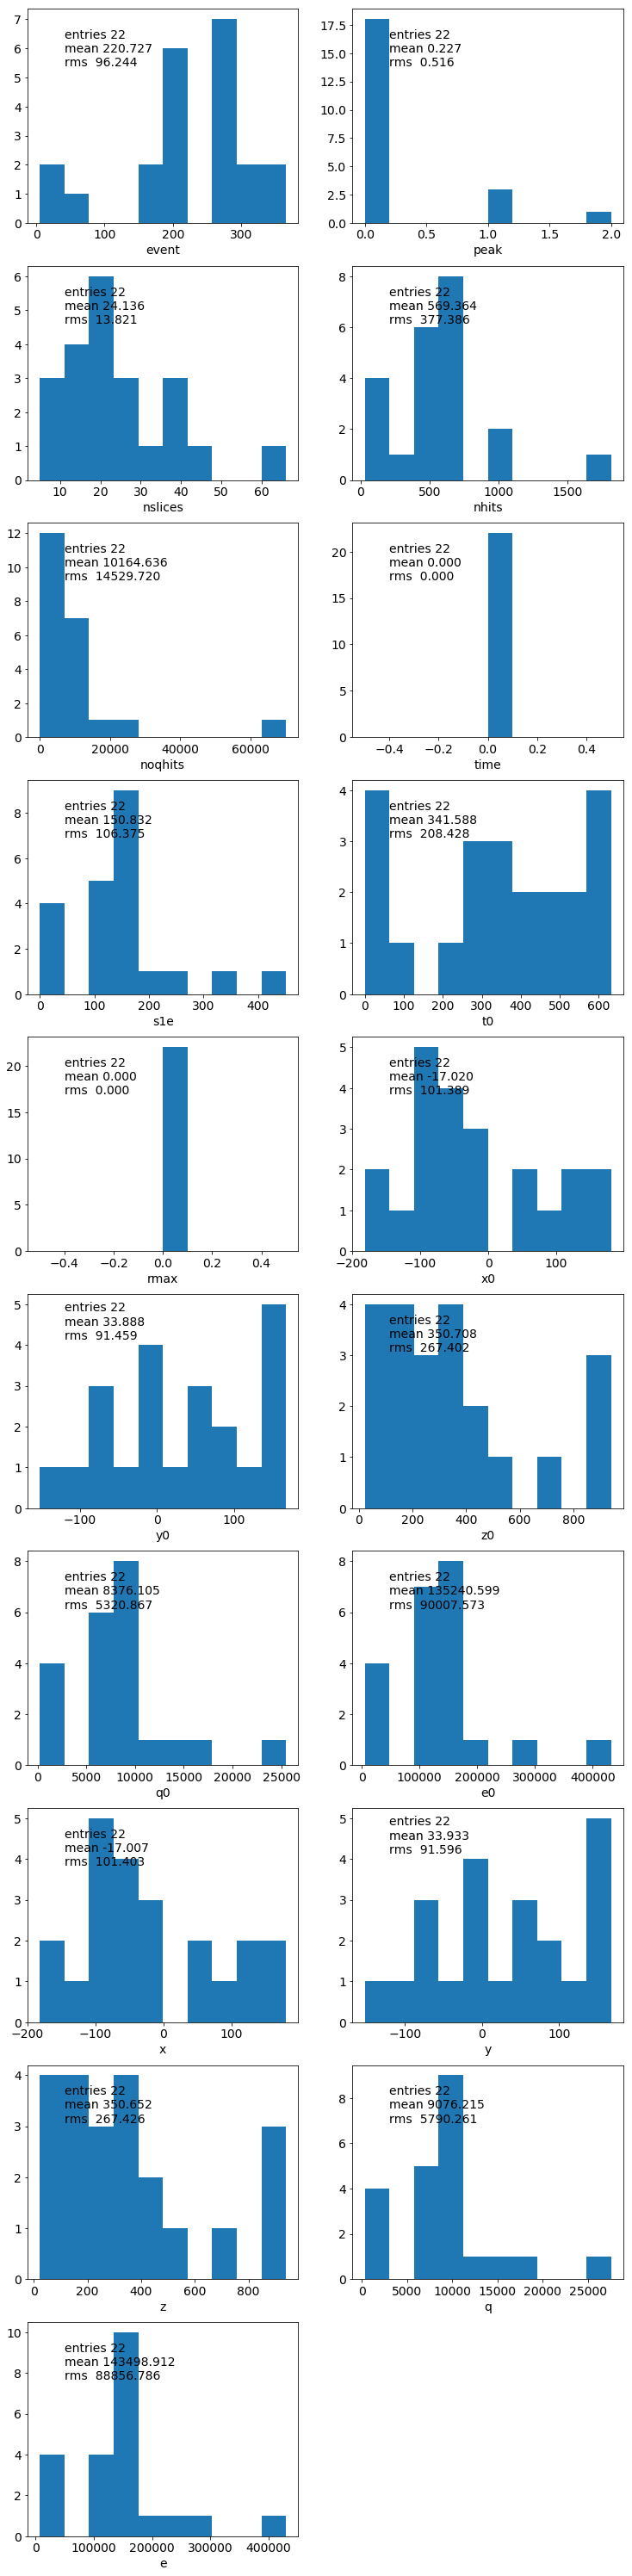

In [25]:
hpplot.plot_var(edf, hptab.edf_names, 10)

In [26]:
evtlist

EventList(event=[5, 9, 47, 160, 178, 188, 192, 213, 217, 220, 261, 271, 273, 274, 275, 305, 363, 366], peak=[1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 1])

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


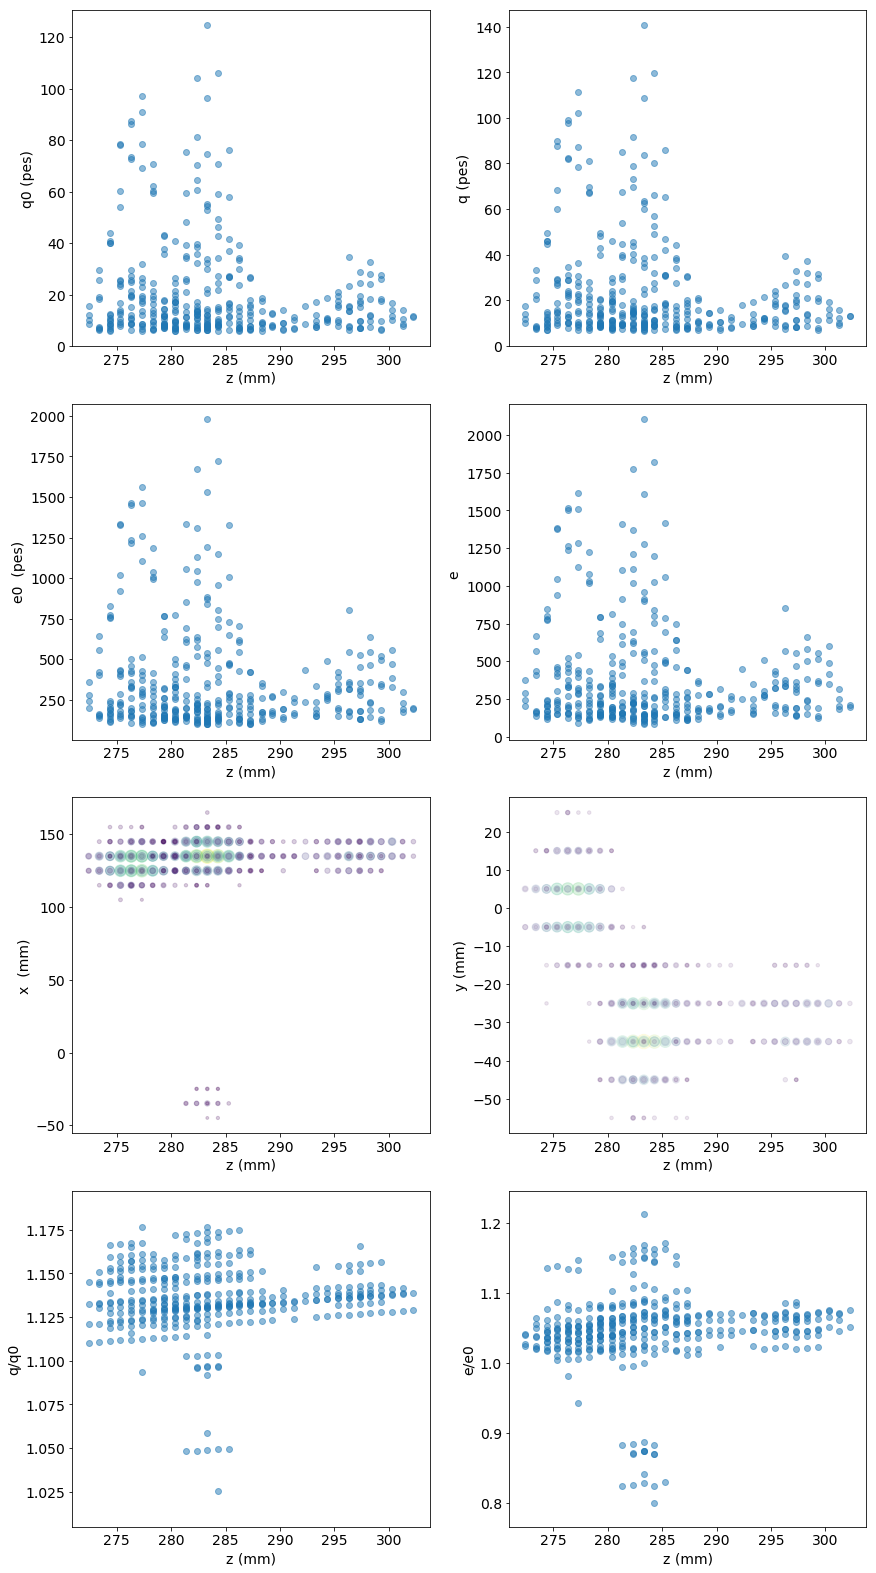

In [27]:
evt = 5
hpplot.plot_vs_z(hdf[hdf.event==evt], q0min = 6.)

/Users/hernando/miniconda/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


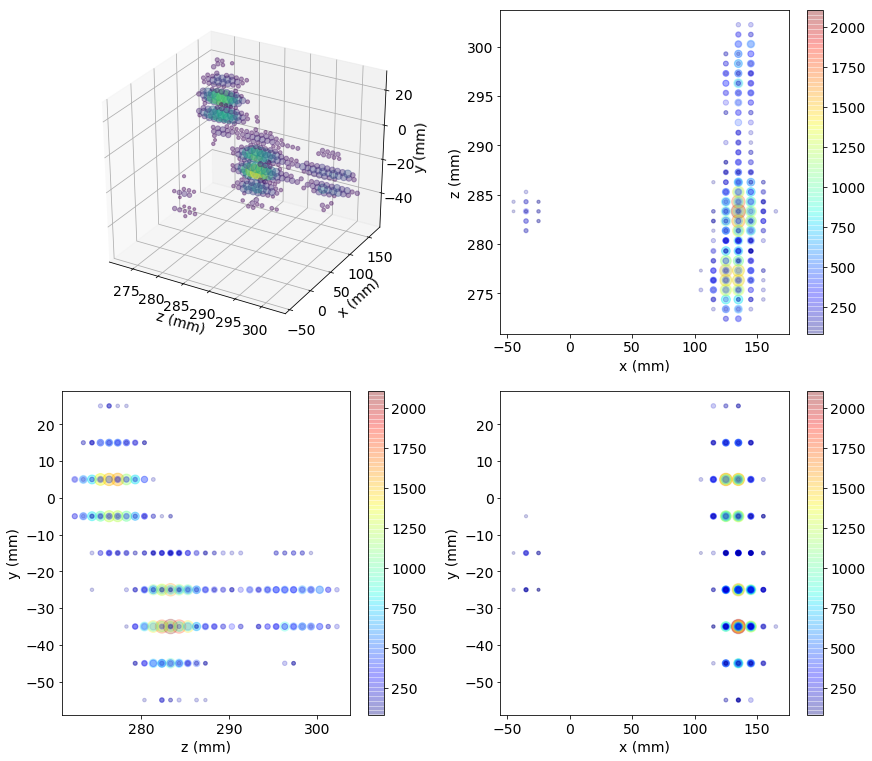

In [28]:
hpplot.graph_hits(hdf[hdf.event == evt], q0min = 6)

In [29]:
print('Done!')

Done!
